In [ ]:
from psutil import virtual_memory
import torch

# colab-GPU 사용 확인
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU 연결 실패!')
else:
  print(gpu_info)

# RAM 사용량 체크
ram_gb = virtual_memory().total / 1e9
print('{:.1f} gigabytes of available RAM\n'.format(ram_gb))

# pytorch-GPU 연결 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('학습을 진행하는 기기:',device)

# 구글 드라이브 연결. 만약 직접 데이터셋을 사용한다면 주석 해제.
# from google.colab import drive
# drive.mount('/content/drive')

Mon Apr 10 17:45:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 이미지를 다운로드 받는 과정
from fastai.data.external import untar_data, URLs
import glob

coco_path = untar_data(URLs.COCO_SAMPLE)

In [ ]:
print(coco_path)

/root/.fastai/data/coco_sample


In [ ]:
# 모든 데이터의 경로를 list로 받아온다.
paths = glob.glob(str(coco_path) + "/train_sample/*.jpg")

In [ ]:
print(paths)

['/root/.fastai/data/coco_sample/train_sample/000000409251.jpg', '/root/.fastai/data/coco_sample/train_sample/000000329035.jpg', '/root/.fastai/data/coco_sample/train_sample/000000193720.jpg', '/root/.fastai/data/coco_sample/train_sample/000000433366.jpg', '/root/.fastai/data/coco_sample/train_sample/000000392839.jpg', '/root/.fastai/data/coco_sample/train_sample/000000514217.jpg', '/root/.fastai/data/coco_sample/train_sample/000000040094.jpg', '/root/.fastai/data/coco_sample/train_sample/000000557508.jpg', '/root/.fastai/data/coco_sample/train_sample/000000290658.jpg', '/root/.fastai/data/coco_sample/train_sample/000000173392.jpg', '/root/.fastai/data/coco_sample/train_sample/000000544626.jpg', '/root/.fastai/data/coco_sample/train_sample/000000486035.jpg', '/root/.fastai/data/coco_sample/train_sample/000000394766.jpg', '/root/.fastai/data/coco_sample/train_sample/000000071507.jpg', '/root/.fastai/data/coco_sample/train_sample/000000514773.jpg', '/root/.fastai/data/coco_sample/train_s

In [ ]:
import numpy as np

np.random.seed(1)
# replace = False 중복을 허용하지 않겠다.
chosen_paths = np.random.choice(paths, 5000, replace=False)
# 5000개 순서를 random하게 index를 만들어 준다.
index = np.random.permutation(5000)


train_paths = chosen_paths[index[:4000]] # 앞 4000장
val_paths = chosen_paths[index[4000:]] # 뒤 1000장
print(len(train_paths),len(val_paths))


4000 1000


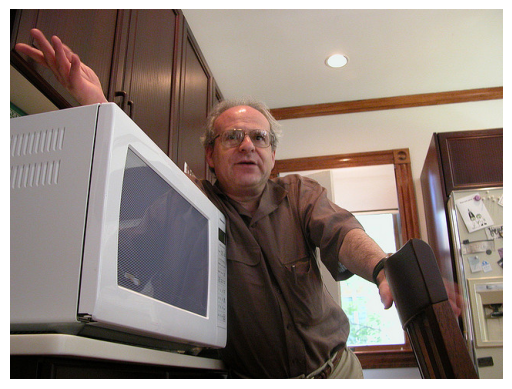

In [ ]:
# 이미지를 출력하는 방법
import matplotlib
import matplotlib.pyplot as plt

img = matplotlib.image.imread(train_paths[0])
plt.imshow(img)
plt.axis('off')
plt.show()

# 클래스 만드는 법

In [ ]:
import torch
from torch.utils.data import Dataset

class myClass(Dataset):
    # 객체가 만들어질 때 기본적으로 실행되는 매서드. 생성자.
    def __init__(self, x, y):
        self.x = x
        self.y = y
    # 인덱스가 주어졌을 때 데이터를 반환하는 함수
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    # 얼마만큼의 인덱스를 사용할지 알려주는 함수
    def __len__(self):
        return self.x.shape[0]


In [ ]:
x = np.random.randint(0, 100, 5)
y = np.random.randint(0, 100, 5)

print(x)
print(y)

[13 76 68 69  3]
[32 20 70 22 97]


In [ ]:
x = torch.Tensor(x)
y = torch.Tensor(y)

print(x)
print(y)

tensor([13., 76., 68., 69.,  3.])
tensor([32., 20., 70., 22., 97.])


In [ ]:
dataset = myClass(x,y)

In [ ]:
print(dataset[1])

(tensor(76.), tensor(20.))


In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=2, num_workers=2, pin_memory=True)

In [ ]:
# 데이터 로더 값을 하나씩 꺼내보는 방법
x,y = next(iter(dataloader))
print(x,y)

tensor([13., 76.]) tensor([32., 20.])


In [ ]:
## 숙제 이미지 Dataloader 만들어보기기

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import numpy as np

class ColorlizationDataset():
    # 생성자를 만들어 봅시다.
    def __init__(self, paths, mode='train'):
        self.mode = mode
        self.paths = paths

        if mode == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((256,256), Image.BICUBIC),
                transforms.RandomHorizontalFlip()
            ])
        elif mode == 'val':
            #확인 용도이기 때문에 augmentation을 할 필요가 없다.
            self.transforms =transforms.Resize((256,256), Image.BICUBIC)
        else:
            # 예외처리리
            raise Exception("Train or Validation only")
    
    def __getitem__(self, index):
        #이미지를 불러오는데 전부 색 이미지가 아닐 수 있다.
        #.convert("RGB")를 안불러오면 이미지마다 흑백인지 컬러인지 다를 수 있다.
        img = Image.open(self.paths[index]).convert("RGB")
        #lab를 사용하려면 numpy로 바꿔야한다.
        img = np.array(self.transforms(img))
        #rgb2lab는 float32 array만 받는다.
        img = rgb2lab(img).astype("float32")
        #데이터로더는 Tensor를 받는다. Tensor로 변환해야한다.
        img = transforms.ToTensor()(img)
        #L채널은 0번째에 존재 + 정규화, -1부터 1 사이로 정규화를 하는 것
        L = img[[0], ...] / 50. -1
        #ab채널은 1,2번째 존재 + 정규화, -1부터 1 사이로 정규화를 하는 것
        ab = img[[1,2], ...] / 110.

        # 딕셔너리 형태로 return을 할 것이다.
        # 데이터를 불러올 때 key, value를 불러오듯 가져올 수 있어 편하다.
        return {"L": L, 'ab' : ab}

    def __len__(self):
        #이미지의 개수 = 경로의 개수
        return len(self.paths)
         
        

In [ ]:
dataset_train = ColorlizationDataset(train_paths, mode='train')
dataset_val = ColorlizationDataset(train_paths, mode='val')

dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, pin_memory=True)

# SRCNN

In [ ]:
import torch.nn as nn

class SRCNN(nn.Module):
    # 생성자
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init()

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9//2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5//2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5//2)
        self.relu = nn.ReLU(inplace=True)

    #순전파 함수
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        return x

    

# 3주차 숙제
+ 인풋 레이어 1개 -> conv2d
+ 인코더 6개 -> conv2d BatchNorm2d LeakyReLU 6개
+ 미들 1개
+ 디코더 6개 -> conv2d BatchNorm2d LeakyReLU 6개
+ 아웃풋 레이어 1개 -> conv2d

In [ ]:
import torch.nn as nn

class pix2pix_Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_layer = nn.Sequential(
            # input이 흑백이라서
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False)
        )

        self.encoder_1 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128)
        )

        self.encoder_2 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256)
        )

        self.encoder_3 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512)
        )

        self.encoder_4 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512)
        )

        self.encoder_5 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512)
        )

        self.encoder_6 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512)
        )

        self.middle = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )

        self.decoder_6 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )

        self.decoder_5 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )

        self.decoder_4 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )

        self.decoder_3 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5)
        )

        self.decoder_2 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5)
        )

        self.decoder_1 = nn.Sequential(
            # inplace=True 업데이트 할때 새로운 변수를 만드는 것이 아니라 원래 있던 변수에다 업데이트를 하겠다.
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5)
        )

        self.output_layer = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    #순전파
    def forward(self, x):
        input_layer = self.input_layer(x)

        encoder_1 = self.encoder_1(input_layer)
        encoder_2 = self.encoder_2(encoder_1)
        encoder_3 = self.encoder_3(encoder_2)
        encoder_4 = self.encoder_4(encoder_3)
        encoder_5 = self.encoder_5(encoder_4)
        encoder_6 = self.encoder_6(encoder_5)

        middle = self.middle(encoder_6)

        cat_6 = torch.cat((middle, encoder_6), dim=1)
        decoder_6 = self.decoder_6(cat_6)
        cat_5 = torch.cat((decoder_6, encoder_5), dim=1)
        decoder_5 = self.decoder_5(cat_5)
        cat_4 = torch.cat((decoder_5, encoder_4), dim=1)
        decoder_4 = self.decoder_4(cat_4)
        cat_3 = torch.cat((decoder_4, encoder_3), dim=1)
        decoder_3 = self.decoder_3(cat_3)
        cat_2 = torch.cat((decoder_3, encoder_2), dim=1)
        decoder_2 = self.decoder_2(cat_2)
        cat_1 = torch.cat((decoder_2, encoder_1), dim=1)
        decoder_1 = self.decoder_1(cat_1)

        output_layer = self.output_layer(decoder_1)

        return output_layer

In [ ]:
#class 선언
    #생성자 선언 : def __init__()
    # super

    # model(layer 선언) nn.Sequential()
        #conv2(3, 64)
        #leakyrelu

        #conv2(3, 64)
        #BatchNorm2d
        #relu

        #conv2(3, 64)
        #BatchNorm2d
        #relu

        #conv2(3, 64)
        #BatchNorm2d
        #relu

        #conv2(3, 64)
        

    #def forward(순전파 함수)
        # 인풋 들어온 녀석을 위에서 만든 model에 넣어서 아웃풋을 뽑고
        # return


In [ ]:
class pix2pix_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            # 참과 거짓만 판별하면 되기 때문에 channel이 1이다.
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False)
        )

    def forward(self, x):
        return self.model(x)

# weight 초기화

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        # _의 의미 : 원래 없는 값을 덮어씌워서(?)
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        print("nn.Conv2d initialized")
    elif type(m) == nn.ConvTranspose2d:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        print("nn.ConvTranspose2d initialized")
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(m.bias.data, 0.)
        print("nn.BatchNorm2d initialized")

def initialize_model(model):
    model.apply(init_weights)
    return model

# Loss 함수

In [ ]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()

        #텐서를 저장하기 위함, 
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        # fake_label = torch.tensor(0.0)

        # 활성화 함수가 포함되어 있다.(sigmoid함수가 같이 붙어있다.)
        self.loss = nn.BCEWithLogitsLoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
            #사이즈를 맞춰주는 함수
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# 이미지 확인 함수
+ utils.py

In [ ]:
def lab_2_rgb(L, ab):
    #정규화 반대로
    L = (L + 1.) * 50.
    ab = ab* 110.

    # 원래 우리가 만든 torch.cat의 이미지 [배치사이즈, 채널, 256, 256] -> [배치사이즈, 256, 256, 채널]
    # 모양을 바꿔주었다.
    Lab = torch.cat([L,ab], dim=1).permute(0,2,3,1).cpu().numpy()

    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    
    return np.stack(rgb_imgs, axis=0)

In [ ]:
import warnings
import torch.optim as optim
from tqdm.notebook import tqdm


# Generator 모델 선언 + 초기화, GPU로 보내기
model_generator = initialize_model(pix2pix_Generator())
model_generator.to(device)

# Discriminator 모델 선언 + 초기화, GPU로 보내기
model_discriminator = initialize_model(pix2pix_Discriminator())
model_discriminator.to(device)

criterion = GANLoss().to(device)
# 파이토치가 짜놓은 함수로 GPU로 보내지 않아도 된다.
L1 = nn.L1Loss()

optimizer_generator = optim.Adam(model_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(model_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


epochs = 100

for e in range(epochs):
    for index, data in enumerate(tqdm(dataloader_train)):
        L = data['L'].to(device)
        ab = data['ab'].to(device)

        #가짜 그림 생성
        fake_color = model_generator(L)

        #### discriminator 훈련 시작 ####
        model_discriminator.train()

        # 아래에서 freeze된 discriminator를 unfreeze해 주자.
        for parameter in model_discriminator.parameters():
            parameter.requires_grad = True

        # 파이토치는 optimizer의 grad를 계속 저장한다.
        # 그래서 초기화 시켜준다.
        optimizer_discriminator.zero_grad()

        #가짜 이미지를 만들어서 discriminator에 넣고 loss 계산
        fake_image = torch.cat((L, fake_color), dim=1)

        #generator가 만든 faek_image를 넣을 때 generator는 학습중인데 그걸 discriminator에 넣어주면
        #두개 다 학습되는 문제가 발생해서 fakeimage를 복사해주고 grad를 떼준다.
        fake_preds = model_discriminator(fake_image.detach())
        loss_discriminator_fake = criterion(fake_preds, False)
        
        #진짜 이미지를 만들어서 discriminator에 넣고 loss 계산
        real_image = torch.cat([L, ab], dim=1)
        real_preds = model_discriminator(real_image)
        loss_discriminator_real = criterion(real_preds, True)

        #두가지 로스를 하나로 합쳐서 backpropagation을 시키고 optimize 시킨다.
        loss_discriminator_total = (loss_discriminator_fake + loss_discriminator_real) * 0.5
        loss_discriminator_total.backward()
        optimizer_discriminator.step()

        #### generator 훈련 시작 ####
        model_generator.train()

        # 훈련을 잠시 비켜주는 코드 (freezing)
        # Generator를 학습해야하니 Discriminator를 freeze 시킨다.
        for parameter in model_discriminator.parameters():
            parameter.requires_grad = False
        
        optimizer_generator.zero_grad()

        # 가짜 이미지를 만들어봅시다.
        fake_image = torch.cat([L, fake_color], dim=1)
        fake_preds = model_discriminator(fake_image)
        loss_generator_GAN = criterion(fake_preds, True)
        loss_generator_L1 = L1(fake_color, ab) * 100
        loss_generator_total = loss_generator_GAN + loss_generator_L1

        loss_generator_total.backward()
        optimizer_generator.step()

        if index % 50 == 0:
            print(f"\nEpcoh {e+1}/{epochs}")
            print(f"Iteration {index}/{len(dataloader_train)}")

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model_generator.eval()
                with torch.no_grad():
                    L = data['L'].to(device)
                    ab = data['ab'].to(device)
                    fake_color = model_generator(L)

                model_generator.train()
                fake_color = fake_color.detach()
                real_color = ab
                
                fake_imgs = lab_2_rgb(L, fake_color)
                real_imgs = lab_2_rgb(L, real_color)

                fig = plt.figure(figsize=(10,8))
                ax = plt.subplot(3, 3, 1)
                ax.imshow(L[1][0].cpu(), cmap='gray')
                ax.axis("off")

                ax = plt.subplot(3, 3, 2)
                ax.imshow(fake_imgs[1])
                ax.axis("off")

                ax = plt.subplot(3, 3, 3)
                ax.imshow(real_imgs[1])
                ax.axis("off")

                plt.show()

Output hidden; open in https://colab.research.google.com to view.